In [14]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation|
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [15]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, \
train_model_cross_val, train_model_test

In [16]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_11.json")

df.drop_duplicates(subset=['article_new', 'case_num', 'file', 'section_fin'], keep='first', inplace=True)
df=df.reset_index(drop=True)

In [17]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['statement objection', 'en', 'phase ii', 'rfi', 'request information']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

In [7]:
label_name = "phase2"

In [8]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [9]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

In [12]:
# Define model
model = LogisticRegression()

# Create a pipeline with TfidfVectorizer and Logit
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2),(1,1),(1,3), (2,2),(2,3), (2,4), (3,3), (3,4)],
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.25, 0.5, 0.75, 1.0], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the logit
}

In [11]:
# c = 5
# solver = 'liblinear'
# model = LogisticRegression(C=c, solver=solver)

# # Create a pipeline with TfidfVectorizer and Logit
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
#     ('clf', model)

# ])

# # Define the grid of hyperparameters to search over
# parameters = {
#     'tfidf__ngram_range': [(3,3),(3,4)],
#     'tfidf__max_df': [0.25, 0.5, 0.75, 1.0], # ignore words that occur as more than 1% of corpus
#     # 'tfidf__use_idf': (False, True), # use inverse document frequency weighting
#     # 'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
#     'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
# }

In [ ]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Top 10 features by importance:
1. commission request information: 1.008
2. large industrial customer: 0.868
3. oe spinning machine: 0.861
4. coal iron ore: 0.845
5. digital map database: 0.798
6. di benzoate plasticizer: 0.794
7. time sensitive passenger: 0.791
8. quarter year index: 0.778
9. cruise ship market: 0.756
10. company issued equity: 0.750


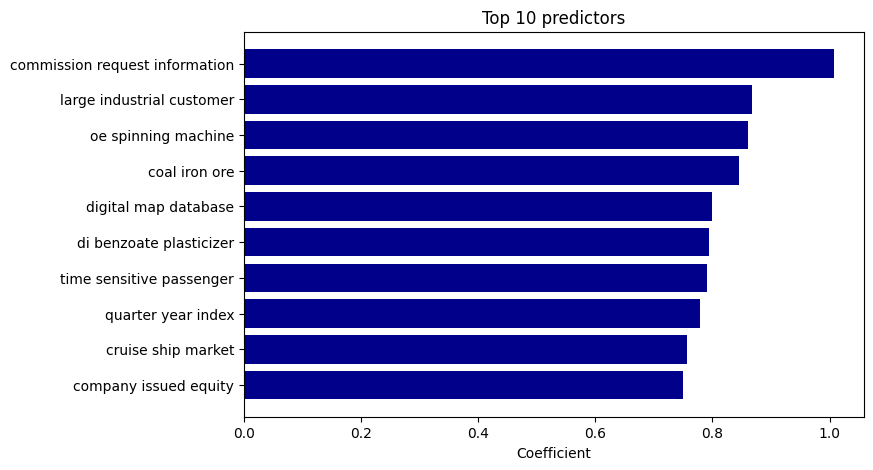

In [13]:
best_pipeline = grid_search.best_estimator_ # get the best pipeline from GridSearchCV
best_model = best_pipeline.named_steps['clf'] # get the best model from the pipeline

if isinstance(best_model, LogisticRegression):
    feature_importances = best_model.coef_[0]
# elif isinstance(best_model, DecisionTreeClassifier) or isinstance(best_model, RandomForestClassifier):
#     feature_importances = best_model.feature_importances_
else:
    raise ValueError("Unsupported model type")

# Get the TfidfVectorizer object from the pipeline
tfidf_vectorizer = best_pipeline.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of feature names and their corresponding coefficients
coef_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by the absolute value of the coefficients
sorted_coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: (item[1]), reverse=True)} # should I use absolute value?

# Print the top 10 most important features
print("Top 10 features by importance:")
for i, (feature, coef) in enumerate(sorted_coef_dict.items()):
    if i == 10:
        break
    print(f"{i+1}. {feature}: {coef:.3f}")

# Get the top 10 features and their coefficients
top_features_0 = list(sorted_coef_dict.keys())[:10]
top_coefs_0 = list(sorted_coef_dict.values())[:10]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5))
y_pos = range(len(top_features_0))
ax.barh(y_pos, top_coefs_0, align='center', color='darkblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features_0)
ax.invert_yaxis()
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 predictors')
plt.show()

In [26]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.7834394904458599

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.76        79
           1       0.74      0.87      0.80        78

    accuracy                           0.78       157
   macro avg       0.79      0.78      0.78       157
weighted avg       0.79      0.78      0.78       157


CR: (0.7926421404682273, 0.7839987017202208, 0.7819444444444444, None)

Confusion matrix:
 [[55 24]
 [10 68]] 

_______________________


 Accuracy: 78.34 
 Precision: 0.739 
 Recall: 0.872 
 F1: 0.800


In [14]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	tfidf__max_df: 0.5
	tfidf__ngram_range: (3, 4)
	tfidf__norm: 'l2'


In [15]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', ngram_range = (3,4), binary = True, max_df = 0.4, norm = 'l2', use_idf = False))
c = 5
solver = 'liblinear'

In [37]:
pipeline_train, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.9171974522292994

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92        79
           1       0.92      0.91      0.92        78

    accuracy                           0.92       157
   macro avg       0.92      0.92      0.92       157
weighted avg       0.92      0.92      0.92       157


CR: (0.917288961038961, 0.9171535215839013, 0.9171840129843781, None)

Confusion matrix:
 [[73  6]
 [ 7 71]] 

_______________________


 Accuracy: 91.72 
 Precision: 0.922 
 Recall: 0.910 
 F1: 0.916


In [49]:
evaluate(y_train, y_predict_train)

Accuracy: 0.9171974522292994

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92        79
           1       0.92      0.91      0.92        78

    accuracy                           0.92       157
   macro avg       0.92      0.92      0.92       157
weighted avg       0.92      0.92      0.92       157


CR: (0.917288961038961, 0.9171535215839013, 0.9171840129843781, None)

Confusion matrix:
 [[73  6]
 [ 7 71]] 

_______________________


 Accuracy: 91.72 
 Precision: 0.922 
 Recall: 0.910 
 F1: 0.916


In [38]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9384184744576627

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1409
           1       0.17      0.90      0.29        20

    accuracy                           0.94      1429
   macro avg       0.59      0.92      0.63      1429
weighted avg       0.99      0.94      0.96      1429


CR: (0.5857837445573295, 0.9194819020581972, 0.6290676546239706, None)

Confusion matrix:
 [[1323   86]
 [   2   18]] 

_______________________


 Accuracy: 93.84 
 Precision: 0.173 
 Recall: 0.900 
 F1: 0.290
